In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.15/01


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ):
        #work in frame that is aligned with photon
        #the photon is aligned with z-direction and has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)        
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.W = (virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        #print ' Angle my way ', self.PhiPQ
        #print 'Hayk (radians) ' , PhiPQ*np.pi/180.0
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        #print 'My COSPQ' , np.arctan(self.Pt/self.Pl)
        #print 'Hayk COSPQ', self.ThetaPQ
        
    def redefine(self, new_virtual_photon):
        #this methods recalculates variables that depend on virtual photon direction
        #this helps for event mixing. 
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
       
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
        
        
    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y
        print 'pid = ' , self.pid

In [5]:

def getDataframes(filename, Target=1,maxevents=1e9):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('tree_data')
    e_tree = myfile.Get('e_rec')
    
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    tupla = {}
    tupla['dphi'] = []
    tupla['dphi_lab'] = []

    tupla['dy'] = []
    tupla['z'] = [] 
    tupla['z_asso'] = []
    tupla['xf'] = []
    tupla['xf_asso'] = []
    tupla['y'] = []
    tupla['ycm'] = []

    tupla['y_asso'] = []
    tupla['pid'] = []
    tupla['pid_asso'] = []
    tupla['phi_pq'] = []
    tupla['phi_pq_asso'] = []
    tupla['theta_pq'] = []  
    tupla['theta_pq_asso'] = []  

    tupla['mass'] = []
    tupla['dipion_pt'] = []
    tupla['missing_mass'] = []
    tupla['t']  = []
    tupla['Q2'] = [] 
    tupla['Nu'] = []
    tupla['W']  = []
    tupla['Xb'] = []
    tupla['u']  = []
    tupla['phi_lab'] = []
    tupla['theta_lab'] = []
    tupla['phi_lab_asso'] = []
    tupla['theta_lab_asso'] = []
    
    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dphi_lab'] = []

    tupla_mix['dy'] = []
    tupla_mix['z'] = []
    tupla_mix['z_asso'] = []
    tupla_mix['xf'] = []
    tupla_mix['xf_asso'] = []
    tupla_mix['y'] = []
    tupla_mix['ycm'] = []

    tupla_mix['y_asso'] = []
    tupla_mix['pid'] = []
    tupla_mix['pid_asso'] = []
    tupla_mix['phi_pq']   = []
    tupla_mix['phi_pq_asso'] = []
    tupla_mix['theta_pq'] = []
    tupla_mix['theta_pq_asso'] = []

    tupla_mix['mass'] = []
    tupla_mix['dipion_pt'] = []
    tupla_mix['missing_mass'] = []
    tupla_mix['t']  = []
    tupla_mix['Q2'] = []
    tupla_mix['Nu'] = []
    tupla_mix['W']  = []
    tupla_mix['Xb'] = []
    tupla_mix['u']  = []
    tupla_mix['phi_lab'] = []
    tupla_mix['theta_lab'] = []
    tupla_mix['phi_lab_asso'] = []
    tupla_mix['theta_lab_asso'] = []
    tupla_mix['dphi_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['phi_pq_asso_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['theta_pq_asso_norot'] = [] #save variable before rotation to new virtual photon frame

    
    
    
    tupla_trigger = {}
    tupla_trigger['pid'] = []
    tupla_trigger['xf'] = []
    tupla_trigger['xf_default'] = []
    tupla_trigger['z']  = []
    tupla_trigger['y']  = []
    tupla_trigger['ycm'] = []
    tupla_trigger['Q2'] = []
    tupla_trigger['Xb'] = []
    tupla_trigger['Nu'] = []
    tupla_trigger['W'] = []
    tupla_trigger['phi_pq'] = []
    tupla_trigger['theta_pq'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['mass'] = []
    tupla_trigger['phi_lab'] = []
    tupla_trigger['theta_lab'] = []
    
    
    start = time.time()

    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        e_tree.GetEntry(ievt)
        if mytree.W<2.05 or mytree.Q2<1.0: continue
        if ievt>maxevents: break
        if mytree.TargType!=Target: continue
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(e_tree.Pex*e_tree.Pex + e_tree.Pey*e_tree.Pey+ e_tree.Pez*e_tree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(e_tree.Pex, e_tree.Pey, e_tree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        ##alternative calculation of virtual photon
        #scattered electron
        #E    = 5.014
        #Eprime = E-Nu
        #phi_e = -scattered_e.Vect().Phi()
        #alt_scattered_e = ROOT.TLorentzVector()
        #cos_thetae = 1-mytree.Q2/(2*E*Eprime)
        #sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        #alt_scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
        #                       Eprime*sin_thetae*np.sin(phi_e),
        #                       Eprime*cos_thetae,
        #                       Eprime)
        #alt_virtual_photon  = incoming_e - alt_scattered_e
        
        #print 'Comparing normal and alternative virtual photons momentum'
        #print 'virtual ',virtual_photon.Px(), ' ', virtual_photon.Py(), ' ', virtual_photon.Pz(), ' ',virtual_photon.E()
        #print 'alt ' ,alt_virtual_photon.Px(), ' ', alt_virtual_photon.Py(), ' ',alt_virtual_photon.Pz(), ' ',alt_virtual_photon.E()
        #################################################
        
        
        
        #photon-nucleon center-of-mass energy and rapidity
        #the photon is aligned with z-direction and has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)
        
     
        #print 'W ',  W , 'electron W ', e_tree.W
        #print (virtual_photon + proton).M()
        particles = []
        #print ' Entering main loop over particles'
        for i in range(len(mytree.pid)):
            if abs(mytree.pid[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu)
#            print i_lv.Phi(), '   ', mytree.Phi[i]*np.pi/180.0
            
            
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] )
            #print i_part.LorentzVector.Phi()
            #print mytree.Phi[i]*np.pi/180.0
            #print i_part.LorentzVector.Theta(), '   ', mytree.Theta[i]*np.pi/180.0

            particles.append(i_part)                

            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
                tupla_trigger['TargType'].append(mytree.TargType)
                tupla_trigger['pid'].append(i_part.pid)
                tupla_trigger['xf'].append(i_part.Xf)
                tupla_trigger['xf_default'].append(mytree.Xf[i])
                tupla_trigger['z'].append(i_part.Zh)
                tupla_trigger['y'].append(i_part.y_star)
                tupla_trigger['ycm'].append(i_part.ycm)
                tupla_trigger['phi_pq'].append(i_part.PhiPQ)
                tupla_trigger['theta_pq'].append(i_part.ThetaPQ)
                tupla_trigger['mass'].append(i_part.LorentzVector.M())
                tupla_trigger['Q2'].append(mytree.Q2)
                tupla_trigger['Xb'].append(mytree.Xb)
                tupla_trigger['Nu'].append(mytree.Nu)
                tupla_trigger['W'].append(mytree.W)
                tupla_trigger['phi_lab'].append(i_part.LorentzVector.Phi())
                tupla_trigger['theta_lab'].append(i_part.LorentzVector.Theta())
                #print 'mytree.Pt[i] ' , mytree.Pt[i], ' check: ' ,i_part.Vector.Perp(virtual_photon_unitvector)
                for j in range(len(mytree.pid)): 
                    if i==j: continue
                    if abs(mytree.pid[j]) !=211: continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                    j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] )
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))

                    
                    dy = i_part.y-j_part.y
                    deta = dy
                    dipion = i_part.LorentzVector+j_part.LorentzVector
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system
                    tupla['dphi'].append(dphi)
                    tupla['dphi_lab'].append(dphi_lab)
                    tupla['dy'].append(dy)
                    tupla['z'].append(i_part.Zh)
                    tupla['z_asso'].append(j_part.Zh)
                    tupla['xf'].append(i_part.Xf)
                    tupla['xf_asso'].append(j_part.Xf)
                    tupla['y'].append(i_part.y_star)
                    tupla['ycm'].append(i_part.ycm)
                    tupla['y_asso'].append(j_part.y_star)
                    tupla['pid'].append(i_part.pid)
                    tupla['pid_asso'].append(j_part.pid)
                    tupla['phi_pq'].append(i_part.PhiPQ)
                    tupla['phi_pq_asso'].append(j_part.PhiPQ)
                    tupla['theta_pq'].append(i_part.ThetaPQ)
                    tupla['theta_pq_asso'].append(j_part.ThetaPQ)
                    tupla['mass'].append(dipion.M())
                    tupla['dipion_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla['missing_mass'].append(X.M())
                    tupla['t'].append( -(virtual_photon- dipion).M2())
                    tupla['Q2'].append(mytree.Q2)
                    tupla['Xb'].append(mytree.Xb)
                    tupla['Nu'].append(mytree.Nu)
                    tupla['W'].append(mytree.W)
                    tupla['u'].append(-(scattered_e-proton).M2())
                    tupla['phi_lab'].append(i_part.LorentzVector.Phi())
                    tupla['theta_lab'].append(i_part.LorentzVector.Theta())
                    tupla['phi_lab_asso'].append(j_part.LorentzVector.Phi())
                    tupla['theta_lab_asso'].append(j_part.LorentzVector.Theta())
                    #end loop over secondary loop    
                #print '//////// Entering mixed event correlations with # ', len(ParticlesFromPrevious) , ' paticles in previous event'
                for mixparticle in ParticlesFromPrevious:
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)
                    tupla_mix['phi_pq_asso_norot'].append(mixparticle.PhiPQ)
                    tupla_mix['theta_pq_asso_norot'].append(mixparticle.ThetaPQ)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    #dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    #print 'dphi_pq after redefinition: ', dphi , ' phi_pq ', mixparticle.PhiPQ
                    
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X = (virtual_photon + proton - dipion)
                    #recalculate the phi_pq. It has to be with respect to the photon direction
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-mixparticle.PhiLab))

                    dy = i_part.y-mixparticle.y
                    deta = dy#i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dphi_lab'].append(dphi_lab)
                    tupla_mix['dy'].append(dy)
                    tupla_mix['z'].append(i_part.Zh)
                    tupla_mix['z_asso'].append(mixparticle.Zh)
                    tupla_mix['xf'].append(i_part.Xf)
                    tupla_mix['xf_asso'].append(mixparticle.Xf)
                    tupla_mix['y'].append(i_part.y)
                    tupla_mix['ycm'].append(i_part.ycm)
                    tupla_mix['y_asso'].append(mixparticle.y)
                    tupla_mix['pid'].append(i_part.pid)
                    tupla_mix['pid_asso'].append(mixparticle.pid)
                    tupla_mix['phi_pq'].append(i_part.PhiPQ)
                    tupla_mix['phi_pq_asso'].append(mixparticle.PhiPQ)
                    tupla_mix['theta_pq'].append(i_part.ThetaPQ)
                    tupla_mix['theta_pq_asso'].append(i_part.ThetaPQ)

                    tupla_mix['mass'].append(dipion.M())    
                    tupla_mix['dipion_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla_mix['missing_mass'].append(X.M())
                    tupla_mix['t'].append(-(virtual_photon- dipion).M2())
                    tupla_mix['Q2'].append(mytree.Q2)
                    tupla_mix['Xb'].append(mytree.Xb)
                    tupla_mix['Nu'].append(mytree.Nu)
                    tupla_mix['W'].append(mytree.W)
                    tupla_mix['u'].append( -(scattered_e-proton).M2())
                    tupla_mix['phi_lab'].append(i_part.LorentzVector.Phi())
                    tupla_mix['theta_lab'].append(i_part.LorentzVector.Theta())
                    tupla_mix['phi_lab_asso'].append(mixparticle.LorentzVector.Phi())
                    tupla_mix['theta_lab_asso'].append(mixparticle.LorentzVector.Theta())
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    
    df = pd.DataFrame(tupla)
    df_mix= pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    print 'Number of triggers with z>0.4,  ', df.query('z>0.4').shape[0]
    print 'Number of pairs with z>0.4, ' ,df_trigger.query('z>0.4').shape[0] 
    myfile.Close()
    return df, df_mix, df_trigger

In [ ]:
#for a particle on-shell:
# E = mT cosh y 
# pz = mT sinh y
#mT2 = m2 + pt2
# rapidity in the ion-at-rest frame, with the photon direction is 
# y = 0.5 * ln( (E+pz)/(E-pz))
#rapidity of the target in the lab frame = 0 (at rest)
# y = y* + ycm
#bcm = az + bz/ a0 + b0 
#bcm = photon_z / Nu + m_{p}
#ycm = 0.5 * ln( 1+bcm/1-bcm)
#energy of the photon = Nu
#momentum of the photon (magnitude) = sqrt(Nu2 + Q2) 
#q2 = -Q2. (four-momentum transfer)

## Create dataframe df

In [3]:
df = {}

## Pb data

In [6]:
path = '/mnt/c/Users/marratia/Linux/Pb_data/'

Files = listdir(path) 
df['Pb'],df['Pb_mix'], df['Pb_trigger'] = [None,None,None]
df['D_Pb'],df['D_Pb_mix'], df['D_Pb_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Pb'] = pd.concat([ df['Pb'], pairs])
    df['Pb_mix'] = pd.concat([ df['Pb_mix'], pairs_mix])
    df['Pb_trigger'] = pd.concat([ df['Pb_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Pb'] = pd.concat([ df['D_Pb'], pairs])
    df['D_Pb_mix'] = pd.concat([ df['D_Pb_mix'], pairs_mix])
    df['D_Pb_trigger'] = pd.concat([ df['D_Pb_trigger'], trigger])

/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41762.root  has  200510  entries


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


Processed in 34.570032835 seconds
Number of triggers with z>0.4,   919
Number of pairs with z>0.4,  4267
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41762.root  has  200510  entries
Processed in 87.3454740047 seconds
Number of triggers with z>0.4,   4602
Number of pairs with z>0.4,  18764
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41763.root  has  190818  entries
Processed in 43.4511590004 seconds
Number of triggers with z>0.4,   848
Number of pairs with z>0.4,  4064
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41763.root  has  190818  entries
Processed in 82.7825348377 seconds
Number of triggers with z>0.4,   4366
Number of pairs with z>0.4,  17829
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41765.root  has  23948  entries
Processed in 3.78554010391 seconds
Number of triggers with z>0.4,   100
Number of pairs with z>0.4,  525
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41765.root  has  23948  entries
Processed in 11.3673892021 seconds
Number of 

Processed in 89.2290911674 seconds
Number of triggers with z>0.4,   4621
Number of pairs with z>0.4,  18914
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41809.root  has  194775  entries
Processed in 33.3672258854 seconds
Number of triggers with z>0.4,   872
Number of pairs with z>0.4,  4108
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41809.root  has  194775  entries
Processed in 82.4602091312 seconds
Number of triggers with z>0.4,   4522
Number of pairs with z>0.4,  18322
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41810.root  has  198405  entries
Processed in 33.3476018906 seconds
Number of triggers with z>0.4,   885
Number of pairs with z>0.4,  4164
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41810.root  has  198405  entries
Processed in 83.9184880257 seconds
Number of triggers with z>0.4,   4649
Number of pairs with z>0.4,  18614
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41811.root  has  200656  entries
Processed in 32.7674911022 seconds
Numb

Processed in 30.9198150635 seconds
Number of triggers with z>0.4,   957
Number of pairs with z>0.4,  4350
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41830.root  has  209045  entries
Processed in 80.0124559402 seconds
Number of triggers with z>0.4,   4867
Number of pairs with z>0.4,  19775
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41831.root  has  213141  entries
Processed in 31.84847188 seconds
Number of triggers with z>0.4,   970
Number of pairs with z>0.4,  4541
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41831.root  has  213141  entries
Processed in 81.4745960236 seconds
Number of triggers with z>0.4,   4913
Number of pairs with z>0.4,  19912
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41832.root  has  199844  entries
Processed in 28.7585251331 seconds
Number of triggers with z>0.4,   880
Number of pairs with z>0.4,  4126
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41832.root  has  199844  entries
Processed in 75.4126429558 seconds
Number o

Processed in 73.9013199806 seconds
Number of triggers with z>0.4,   4392
Number of pairs with z>0.4,  18097
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41867.root  has  191129  entries
Processed in 28.6232068539 seconds
Number of triggers with z>0.4,   820
Number of pairs with z>0.4,  4050
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41867.root  has  191129  entries
Processed in 72.4964921474 seconds
Number of triggers with z>0.4,   4356
Number of pairs with z>0.4,  17875
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41868.root  has  192813  entries
Processed in 28.4893798828 seconds
Number of triggers with z>0.4,   798
Number of pairs with z>0.4,  4035
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41868.root  has  192813  entries
Processed in 74.0390319824 seconds
Number of triggers with z>0.4,   4415
Number of pairs with z>0.4,  18350
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41869.root  has  194121  entries
Processed in 28.8187091351 seconds
Numb

Processed in 19.8949420452 seconds
Number of triggers with z>0.4,   602
Number of pairs with z>0.4,  2871
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41889.root  has  136963  entries
Processed in 51.1576018333 seconds
Number of triggers with z>0.4,   3151
Number of pairs with z>0.4,  12662
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41890.root  has  121925  entries
Processed in 17.7377090454 seconds
Number of triggers with z>0.4,   529
Number of pairs with z>0.4,  2522
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41890.root  has  121925  entries
Processed in 46.2870278358 seconds
Number of triggers with z>0.4,   2749
Number of pairs with z>0.4,  11458
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41891.root  has  134080  entries
Processed in 19.8531899452 seconds
Number of triggers with z>0.4,   576
Number of pairs with z>0.4,  2892
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41891.root  has  134080  entries
Processed in 51.9869308472 seconds
Number

Processed in 53.8447020054 seconds
Number of triggers with z>0.4,   3182
Number of pairs with z>0.4,  13422
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41916.root  has  165710  entries
Processed in 24.2055971622 seconds
Number of triggers with z>0.4,   710
Number of pairs with z>0.4,  3533
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41916.root  has  165710  entries
Processed in 62.1872069836 seconds
Number of triggers with z>0.4,   3839
Number of pairs with z>0.4,  15560
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41917.root  has  79618  entries
Processed in 11.3665628433 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  1611
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41917.root  has  79618  entries
Processed in 30.470692873 seconds
Number of triggers with z>0.4,   1795
Number of pairs with z>0.4,  7415
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41918.root  has  59842  entries
Processed in 8.82585310936 seconds
Number of

Processed in 26.664855957 seconds
Number of triggers with z>0.4,   608
Number of pairs with z>0.4,  3288
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41953.root  has  152694  entries
Processed in 58.4538640976 seconds
Number of triggers with z>0.4,   3465
Number of pairs with z>0.4,  14201
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41954.root  has  195498  entries
Processed in 29.6964728832 seconds
Number of triggers with z>0.4,   903
Number of pairs with z>0.4,  4198
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41954.root  has  195498  entries
Processed in 76.2415690422 seconds
Number of triggers with z>0.4,   4485
Number of pairs with z>0.4,  18456
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41955.root  has  149865  entries
Processed in 22.9915380478 seconds
Number of triggers with z>0.4,   661
Number of pairs with z>0.4,  3122
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41955.root  has  149865  entries
Processed in 57.7012629509 seconds
Number 

Processed in 18.5602321625 seconds
Number of triggers with z>0.4,   1134
Number of pairs with z>0.4,  4579
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41976.root  has  49058  entries
Processed in 7.15992498398 seconds
Number of triggers with z>0.4,   242
Number of pairs with z>0.4,  1048
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41976.root  has  49058  entries
Processed in 19.0806407928 seconds
Number of triggers with z>0.4,   1146
Number of pairs with z>0.4,  4665
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41977.root  has  161751  entries
Processed in 23.6781289577 seconds
Number of triggers with z>0.4,   697
Number of pairs with z>0.4,  3371
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41977.root  has  161751  entries
Processed in 63.5459568501 seconds
Number of triggers with z>0.4,   3833
Number of pairs with z>0.4,  15342
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41981.root  has  178012  entries
Processed in 26.4350831509 seconds
Number o

In [7]:
df['Pb_mix'].keys()

Index([u'Nu', u'Q2', u'W', u'Xb', u'dipion_pt', u'dphi', u'dphi_lab',
       u'dphi_norot', u'dy', u'mass', u'missing_mass', u'phi_lab',
       u'phi_lab_asso', u'phi_pq', u'phi_pq_asso', u'phi_pq_asso_norot',
       u'pid', u'pid_asso', u't', u'theta_lab', u'theta_lab_asso', u'theta_pq',
       u'theta_pq_asso', u'theta_pq_asso_norot', u'u', u'xf', u'xf_asso', u'y',
       u'y_asso', u'ycm', u'z', u'z_asso'],
      dtype='object')

## Fe Data

In [ ]:
path = '/mnt/c/Users/marratia/Linux/Fe_data/'

Files = listdir(path) 
df['Fe'],df['Fe_mix'], df['Fe_trigger'] = [None,None,None]
df['D_Fe'],df['D_Fe_mix'], df['D_Fe_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Fe'] = pd.concat([ df['Fe'], pairs])
    df['Fe_mix'] = pd.concat([ df['Fe_mix'], pairs_mix])
    df['Fe_trigger'] = pd.concat([ df['Fe_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Fe'] = pd.concat([ df['D_Fe'], pairs])
    df['D_Fe_mix'] = pd.concat([ df['D_Fe_mix'], pairs_mix])
    df['D_Fe_trigger'] = pd.concat([ df['D_Fe_trigger'], trigger])

# C data

In [ ]:
path = '/mnt/c/Users/marratia/Linux/C_data/'
Files = listdir(path) 
df['C'],df['C_mix'], df['C_trigger'] = [None,None,None]
df['D_C'],df['D_C_mix'], df['D_C_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['C'] = pd.concat([ df['C'], pairs])
    df['C_mix'] = pd.concat([ df['C_mix'], pairs_mix])
    df['C_trigger'] = pd.concat([ df['C_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_C'] = pd.concat([ df['D_C'], pairs])
    df['D_C_mix'] = pd.concat([ df['D_C_mix'], pairs_mix])
    df['D_C_trigger'] = pd.concat([ df['D_C_trigger'], trigger])

In [ ]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [ ]:
to_root(df['Pb'],'Pairs_Pb.root', key='Pb')
to_root(df['Pb_mix'],'Pairs_Pb.root', key='Pb_mix',mode='a')
to_root(df['Pb_trigger'],'Pairs_Pb.root', key='Pb_trigger', mode='a')
to_root(df['D_Pb'],'Pairs_Pb.root', key='D_Pb',mode='a')
to_root(df['D_Pb_mix'],'Pairs_Pb.root', key='D_Pb_mix',mode='a')
to_root(df['D_Pb_trigger'],'Pairs_Pb.root', key='D_Pb_trigger', mode='a')

In [ ]:
to_root(df['Fe'],'Pairs_Fe.root', key='Fe')
to_root(df['Fe_mix'],'Pairs_Fe.root', key='Fe_mix',mode='a')
to_root(df['Fe_trigger'],'Pairs_Fe.root', key='Fe_trigger', mode='a')
to_root(df['D_Fe'],'Pairs_Fe.root', key='D_Fe',mode='a')
to_root(df['D_Fe_mix'],'Pairs_Fe.root', key='D_Fe_mix',mode='a')
to_root(df['D_Fe_trigger'],'Pairs_Fe.root', key='D_Fe_trigger', mode='a')

In [ ]:
to_root(df['C'],'Pairs_C.root', key='C')
to_root(df['C_mix'],'Pairs_C.root', key='C_mix',mode='a')
to_root(df['C_trigger'],'Pairs_C.root', key='C_trigger', mode='a')
to_root(df['D_C'],'Pairs_C.root', key='D_C',mode='a')
to_root(df['D_C_mix'],'Pairs_C.root', key='D_C_mix',mode='a')
to_root(df['D_C_trigger'],'Pairs_C.root', key='D_C_trigger', mode='a')

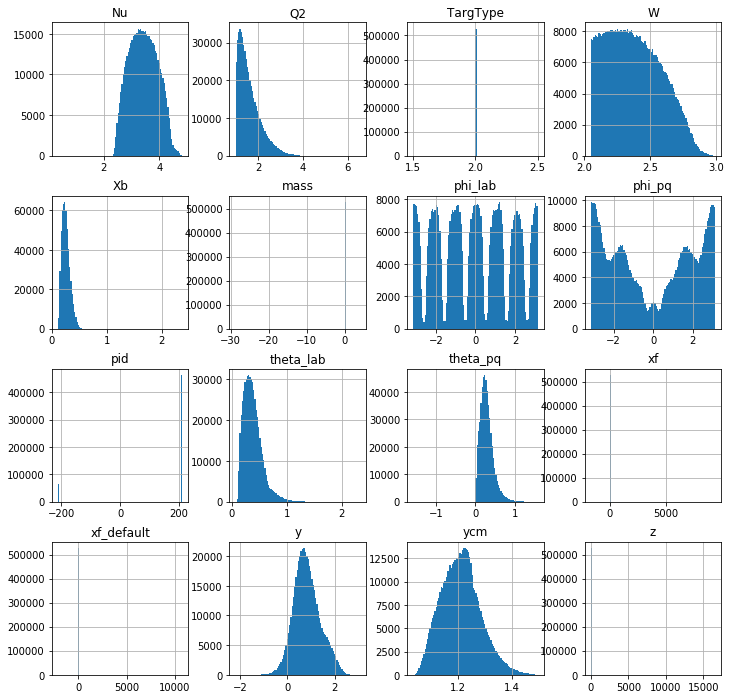

In [9]:
df['Pb_trigger'].hist(figsize=(12,12),bins=100)
plt.show()

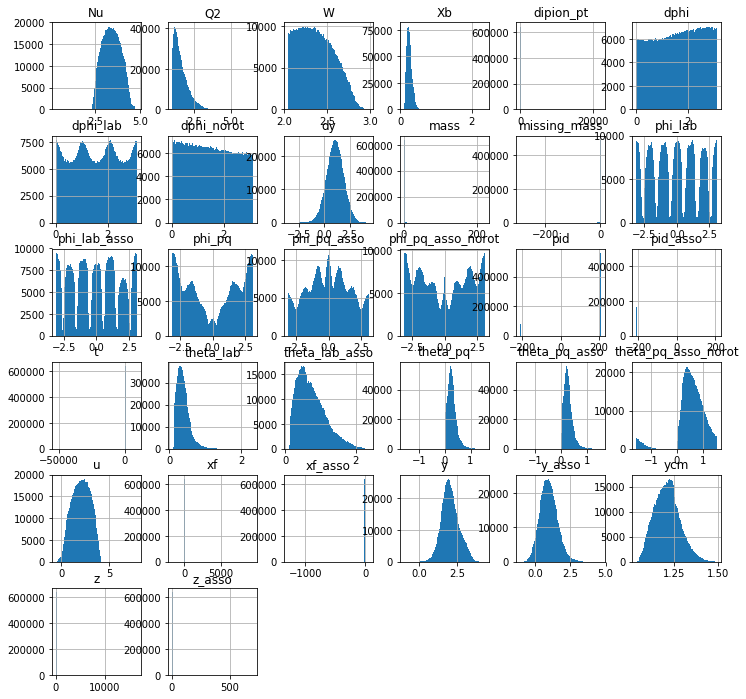

In [11]:
df['Pb_mix'].hist(figsize=(12,12),bins=100)
plt.show()

## See distributions